In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt

In [ ]:
def decode(whole_encoded_df, tables, data):
    
    np_encoded = np.array(whole_encoded_df)
    np_encoded = np_encoded.astype(str)
    restored = pd.DataFrame()
    for k in range(len(np_encoded.transpose())):
        temp1 = []
        for i in np_encoded.transpose()[k]:
            temp2=[]
            a =''
            for j in range(len(i)):
                a+=i[j]
                if((j+1)%3==0):
                    temp2.append(a)
                    if(len(a)!=3):
                        print('error')
                    a=''
            
            temp1.append(temp2)
        sep_df = pd.DataFrame(temp1)
        restored = pd.concat([restored,sep_df],axis=1)
        
    cols = []

    for head in tables:
        for col in data.filter(like=head).columns:
            cols.append(col)
    #restored.columns = cols
    
    return restored

In [ ]:
def restore_day(data,target,multiplier):

    days_arr=[]
    for days in data[target]:
        restored_days = 0
        if days != 0 and days != 999:
            restored_days = days * multiplier + random.randrange(-int(multiplier/2),int(multiplier/2)+1,1)
        elif days ==0:
            restore_days = days + random.randrange(0, int(multiplier/2)+1,1)
        elif days == 999:
            restore_days = np.NaN
        days_arr.append(restored_days)
        
    data[target] =  days_arr

    return data

In [ ]:
data = pd. read_excel('/home/wonseok/2022_DATA_SYNTHESIS/young_age/data/raw/D0_Handmade_ver1.1.xlsx')
data = data.replace('x',999)
data = data.replace('Not Data', np.NaN)

In [1]:
data.head(2)

,PT_SBST_NO,BSPT_SEX_CD,BSPT_IDGN_AGE,BSPT_FRST_DIAG_YMD,BSPT_FRST_DIAG_NM,BSPT_STAG_CLSF_CD,BSPT_STAG_VL,RLPS_DIAG_YMD,5YR_RLPS,RLPS,...,CASB_CSTR_PRPS_NM_7,TRTM_CASB_STRT_YMD7,TRTM_CASB_CSTR_YMD2_7,CSTR_CYCL_VL_END_7,CSTR_REGN_NM_8,CSTR_PRPS_NT_8,CASB_CSTR_PRPS_NM_8,TRTM_CASB_STRT_YMD8,TRTM_CASB_CSTR_YMD2_8,CSTR_CYCL_VL_END_8
0,RN00001835,M,39,2008-01-07,colon,NaN,999.0,NaT,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RN00001096,F,35,2008-01-09,colon,p,3.0,2009-04-03,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# exclude creiteria

# overall observation day is under 30days
data = data[(data.CENTER_LAST_VST_YMD - data.BSPT_FRST_DIAG_YMD).dt.days >= 30]
# missing in whole stage value
cond1 = data['BSPT_STAG_VL'] != 999
data = data[cond1].dropna(subset=['BSPT_STAG_VL'])

# Surgical T Stage value is missing, but have operation report
cond1 = data['OPRT_YMD'].isnull()==True
cond2 = data['SGPT_PATL_T_STAG_VL'].isnull()==True
data = data.drop(data[cond1&cond2].index)

data = data.drop(['OVRL_SRVL_DTRN_DCNT','RLPS_DTRN_DCNT'],axis=1)

# whole data length : 1501 -> after apply exclude criteria : 1253

In [ ]:
standalone = data.iloc[:,:12]
bind = data.iloc[:,12:]

In [ ]:
# categoriziing continous value

standalone['RLPS DIFF'] =  (((standalone['RLPS_DIAG_YMD'] - standalone['BSPT_FRST_DIAG_YMD']) .dt.days)/30).round()
standalone['DEAD'] = data['DEAD']
standalone['BSPT_IDGN_AGE'] = (standalone['BSPT_IDGN_AGE']/5).round().astype(int)
standalone['DEAD_DIFF'] = (((data['BSPT_DEAD_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days)/30).round()
standalone['OVR_SURV'] = (((data['CENTER_LAST_VST_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days)/90).round()
standalone = standalone.drop(['BSPT_FRST_DIAG_YMD','RLPS_DIAG_YMD','5YR_RLPS','CENTER_LAST_VST_YMD','BSPT_DEAD_YMD'], axis =1)

In [ ]:
bind = bind.drop(['DEAD','5YR_DEAD','MLPT_ACPT_YMD','BPTH_ACPT_YMD'],axis=1)
#bind = bind.iloc[:,5:]
bind['OPRT_YMD'] = (((bind['OPRT_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days)/15).round()


col = list(bind.iloc[:,:26].columns)
regn_col= list('REGN_' + bind.iloc[:,26:].columns)

col = col+regn_col
bind.columns = col

In [2]:
data.columns.__len__()
# 본래 컬럼의 수는 91개

91

In [ ]:
for i in range(1,9):
    start = pd.to_datetime(bind[f'REGN_TRTM_CASB_STRT_YMD{i}'],format='%Y%m%d')
    end = pd.to_datetime(bind[f'REGN_TRTM_CASB_CSTR_YMD2_{i}'],format='%Y%m%d')
    
    monthly_diff = (((end-start).dt.days)/30).round()
    start_diff = (((start-data['BSPT_FRST_DIAG_YMD']).dt.days)/15).round()
    
    bind[f'REGN_TRTM_CASB_STRT_YMD{i}'] = monthly_diff
    bind[f'REGN_TRTM_CASB_CSTR_YMD2_{i}'] = start_diff
    
    bind.rename(columns= {f'REGN_TRTM_CASB_STRT_YMD{i}':f'REGN_TIME_DIFF_{i}'},inplace=True)
    bind.rename(columns= {f'REGN_TRTM_CASB_CSTR_YMD2_{i}':f'REGN_START_DIFF_{i}'},inplace=True)
    #bind.drop(f'REGN_TRTM_CASB_CSTR_YMD2_{i}',axis=1,inplace = True)

In [ ]:
# This encodes the data

encoders = []
encode_dict = dict()
for col in bind.columns:
    try:
        bind[col].astype(float)
        encoders.append('non')
    except:
        bind[col].astype(str)
        encoder = LabelEncoder()
        encoder.fit(bind[col])
        
        
        x = {key:i for key, value in dict.fromkeys(encoder.classes_).items()}
        for i, key in enumerate(x.keys()): 
            x[key] = i

        encode_dict[col] = x
        
        encoders.append(encoder)        
        trans = encoder.transform(bind[col])
        bind[col] = trans
        

In [3]:
bind.head()
# 여전히 Nan이 존재하지만 대부분의 값들을 인코딩하였다.
bind.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [4]:
# binding columns by the source tables 

tables= []
for col in bind.columns:
    tables.append('_'.join(col.split('_')[0:1]))

result1 = dict.fromkeys(tables)
uniq_tables = list(result1)
print(uniq_tables)

temp_df=[]
for uniq in uniq_tables:
    temp_series = []
    for col in bind.columns:
        if uniq == '_'.join(col.split('_')[0:1]):
            temp_series.append(bind[col])
            
            
    temp_df.append(pd.DataFrame(temp_series))

['BPTH', 'OPRT', 'SGPT', 'MLPT', 'IMPT', 'REGN']


In [ ]:
# replacing the weird values in the columns

for i in range(len(temp_df)):
    temp_df[i] = temp_df[i].replace(np.NaN, 999)
    temp_df[i] = temp_df[i].astype(int).astype(str)
    for j in range(10):
        temp_df[i] = temp_df[i].replace(str(j),'00'+str(j))
    for k in range(10,100):
        temp_df[i] = temp_df[i].replace(str(k),'0'+str(k))

In [ ]:
# joining the splitted table columns 

results = []
concated = pd.DataFrame()
for i in range(len(temp_df)):
    result = temp_df[i].transpose().iloc[:,0]
    for j in range(1,len(temp_df[i])):
        result += temp_df[i].transpose().iloc[:,j]
        
    a = pd.DataFrame(result)
    col = '_'.join(((uniq_tables)[i].split('_'))[0:1])
    a= a.rename(columns = {result.name : col})
    
    results.append(a)
    
# results captivates values that are split    

In [ ]:
whole_encoded_df = results[0]
for df in results[1:]:
    whole_encoded_df = pd.concat([whole_encoded_df, df],axis=1)

In [ ]:
whole_encoded_df = whole_encoded_df +'r'

In [ ]:
pd.concat([standalone, whole_encoded_df],axis=1).to_csv('encoded_D0.csv',index_label=False)

In [ ]:
unmodified_D0 = pd.concat([standalone,bind],axis=1)
encoders = []
for col in unmodified_D0.columns:
    try:
        unmodified_D0[col].astype(float)
        #encoders.append('non')
    except:
        unmodified_D0[col].astype(str)
        encoder = LabelEncoder()
        encoder.fit(unmodified_D0[col])
        encoders.append(encoder)
        trans = encoder.transform(unmodified_D0[col])
        unmodified_D0[col] = trans
        

In [5]:
data.filter(like="REGN")

,CSTR_REGN_NM_1,CSTR_REGN_NM_2,CSTR_REGN_NM_3,CSTR_REGN_NM_4,CSTR_REGN_NM_5,CSTR_REGN_NM_6,CSTR_REGN_NM_7,CSTR_REGN_NM_8
1,['FOLFOX'],NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,['FOLFOX'],NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,['FOLFOX'],NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
encoded = pd.read_csv('encoded_D0.csv')
sampled = encoded.sample(int(len(encoded)*0.8))
valid = unmodified_D0.drop(sampled.index)


valid['RLPS DIFF'] =  (data['RLPS_DIAG_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days
valid['BSPT_IDGN_AGE'] = data['BSPT_IDGN_AGE']
valid['DEAD_DIFF'] = (data['BSPT_DEAD_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days
valid['OVR_SURV'] = (data['CENTER_LAST_VST_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days

valid['OPRT_YMD'] = ((data['OPRT_YMD'] - data['BSPT_FRST_DIAG_YMD']).dt.days)

for i in range(1,9):
    start = pd.to_datetime(data[f'REGN_TRTM_CASB_STRT_YMD{i}'],format='%Y%m%d')
    end = pd.to_datetime(data[f'REGN_TRTM_CASB_CSTR_YMD2_{i}'],format='%Y%m%d')
    
    monthly_diff = (end-start).dt.days
    start_diff = (start-data['BSPT_FRST_DIAG_YMD']).dt.days
    
    valid[f'REGN_TIME_DIFF_{i}'] = monthly_diff
    valid[f'REGN_START_DIFF_{i}'] = start_diff

sampled.to_csv('encoded_D0_to_syn.csv')

KeyError: 'REGN_TRTM_CASB_STRT_YMD1'

In [7]:
pd.read_csv('/home/dogu86/young_age_colon_cancer/final_data/synthetic_decoded/Synthetic_data_epsilon10000.csv')

,Unnamed: 0,PT_SBST_NO,BSPT_SEX_CD,BSPT_IDGN_AGE,BSPT_FRST_DIAG_NM,BSPT_STAG_CLSF_CD,BSPT_STAG_VL,RLPS,RLPS_DIFF,DEAD,...,REGN_CASB_CSTR_PRPS_NM_7,REGN_TIME_DIFF_7,REGN_START_DIFF_7,REGN_CSTR_CYCL_VL_END_7,REGN_CSTR_REGN_NM_8,REGN_CSTR_PRPS_NT_8,REGN_CASB_CSTR_PRPS_NM_8,REGN_TIME_DIFF_8,REGN_START_DIFF_8,REGN_CSTR_CYCL_VL_END_8
0,0,dltmjnbppr0,1,45,0,2,0.0,1,300.0,1,...,1,29961,29980,999,1,999,1,29957,29963,999
1,1,prxkpngdah1,0,38,2,2,0.0,1,307.0,1,...,1,29956,29983,999,1,999,1,29960,29965,999
2,2,sidonipgqj2,0,40,1,2,3.0,1,198.0,1,...,1,29973,29972,999,1,999,1,29966,29974,999
3,3,uojrzqcovx3,0,43,0,2,2.0,0,NaN,0,...,1,29955,29972,999,1,999,1,29972,29970,999
4,4,kejqgangtc4,1,41,1,2,2.0,0,NaN,0,...,1,29974,29983,999,1,999,1,29957,29984,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,5005,nnljvmuzvc5005,1,39,1,2,1.0,1,NaN,1,...,1,29959,29965,999,1,999,1,29964,29981,999
5006,5006,vjttqgfkeu5006,0,39,0,2,2.0,1,374.0,1,...,1,29965,29978,999,1,999,1,29978,29984,999
5007,5007,bcejiaixcr5007,1,28,2,2,3.0,0,NaN,0,...,1,29969,29981,999,1,999,1,29972,29971,999
5008,5008,ybleaoarle5008,0,28,0,2,3.0,0,NaN,1,...,1,29984,29980,999,1,999,1,29982,29961,999


In [ ]:
import datetime

epsilons = [10000]
for epsilon in epsilons:
    syn = pd.read_csv(f'/home/dogu86/young_age_colon_cancer/final_data/synthetic/S0_mult_encoded_{epsilon}_degree2.csv')
    try:
        syn = syn.drop('Unnamed: 0', axis=1)
    except:
        pass
    syn = syn.astype(str)
    for col in syn.iloc[:,11:]:
        syn[col] =syn[col].str.replace('r','')
        
        
    decoded = decode(syn.iloc[:,11:], tables, bind)
    decoded.columns = bind.columns
    syn = pd.concat([syn.iloc[:,:11],decoded],axis=1)
    syn = syn.rename(columns = {'RLPS DIFF' : 'RLPS_DIFF'})
    
    # continous restore    
    syn['BSPT_IDGN_AGE'] = syn['BSPT_IDGN_AGE'].astype(int)
    ages=[]
    for age in syn['BSPT_IDGN_AGE']:
        if age < 10:
            restored_age = age * 5 + random.randrange(-2,3,1)
        else:
            restored_age = age * 5 + random.randrange(-2,0,1)
        ages.append(restored_age)
        
    syn['BSPT_IDGN_AGE'] =  ages

    days = ['OVR_SURV','RLPS_DIFF','DEAD_DIFF']
    
    for i in range(1,9):
        days.append(f'REGN_TIME_DIFF_{i}')
        days.append(f'REGN_START_DIFF_{i}')
    
    
    for col in days:
        syn[col] = syn[col].astype(float)
        num = 30
        if col == 'OVR_SURV':
            num = 90
        elif col[:4] == 'REGN':
            num = 15
        syn = restore_day(syn, col, num)
    
    
    for col in list(syn.columns)[11:]:
        syn[col] = syn[col].astype(int)
    
    
    # Label Encoding for ml
    ml_data=syn.copy()
    
    for col in ['BSPT_SEX_CD', 'BSPT_FRST_DIAG_NM', 'BSPT_STAG_CLSF_CD']:
        ml_data[col].astype(str)
        encoder.fit(ml_data[col])
        trans = encoder.transform(ml_data[col])
        
        ml_data[col] = trans
    
    ml_data = ml_data.replace(999,np.NaN)
    ml_data = ml_data.replace('999',np.NaN)

    ml_data.to_csv(f'/home/dogu86/young_age_colon_cancer/final_data/synthetic_decoded/Synthetic_data_epsilon{epsilon}.csv')
    
    ####################################################################################################################################
    
    # date time restore with randomly
    start_date = min(data['BSPT_FRST_DIAG_YMD'])
    end_date = max(data['BSPT_FRST_DIAG_YMD'])
    
    date_range = pd.date_range(start_date,end_date,freq='D')

    date = []
    for _ in range(len(syn)):
        date.append(random.choice(date_range))
    
    syn.insert(4,'BSPT_FRST_DIAG_YMD', date)    

    
    for col in ['RLPS', 'DEAD']:
        diff = []
        for i in range(len(syn)):        
            try:
                diff.append((syn['BSPT_FRST_DIAG_YMD'].iloc[i] + datetime.timedelta(days=syn[col+'_DIFF'].iloc[i])).strftime("%Y-%m-%d"))
            except:
                diff.append(0)
        syn.insert(list(syn.columns).index(col)+1 , col+'_YMD' , diff)
        

    for i in range(1,9):
        start_diff = []
        end_diff = []
        for j in range(len(syn)):        
            if syn[f'REGN_START_DIFF_{i}'].iloc[j] != 0:
                start_day = (syn['BSPT_FRST_DIAG_YMD'].iloc[j] + datetime.timedelta(days=int(syn[f'REGN_START_DIFF_{i}'].iloc[j]))).strftime("%Y-%m-%d")
                end_day = datetime.datetime.strptime(start_day,"%Y-%m-%d") + datetime.timedelta(days=int(syn[f'REGN_TIME_DIFF_{i}'].iloc[j]))
                start_diff.append(start_day)
                end_diff.append(end_day.strftime("%Y-%m-%d"))
            else:
                start_diff.append(np.NaN)
                end_diff.append(np.NaN)

        syn[f'REGN_START_DIFF_{i}'] = start_diff

        syn.insert(list(syn.columns).index(f'REGN_START_DIFF_{i}')+1 , f'REGN_END_DAY_{i}' , end_diff)    
        syn = syn.rename({f'REGN_START_DIFF_{i}':f'REGN_START_DAY_{i}'})
        
        
    # numeric to context
    for i in range(len(encoders)):
        try:
            syn[syn.columns[i+14]] = encoders[i].inverse_transform(syn[syn.columns[i+14]])
        except:
            pass

    syn = syn.rename({'REGN_IMPT_HP2E_RSLT_NM':'IMPT_HP2E_RSLT_NM'})
    syn = syn.replace(999,np.NaN)
    #syn = syn.replace(0,'No Data')

    pkl_encode =pd.read_pickle('LabelEncoder.pkl')

    for key in pkl_encode.keys():
        inverse = {}
        for k, v in pkl_encode[key].items():
            inverse[v] = k
        try:
            syn[key] = syn[key].replace(inverse)
        except:
            pass


    syn.to_csv(f'/home/dogu86/young_age_colon_cancer/final_data/synthetic_restore/Synthetic_data_epsilon{epsilon}.csv',encoding='cp949')

In [ ]:
import pickle
encode_dict

with open('LabelEncoder.pkl', 'wb') as f:
    pickle.dump(encode_dict, f)

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

input_path = Path("/home/wonseok/projects/2022_DATA_SYNTHESIS/young_age/")
df = pd.read_excel(input_path.joinpath('data/raw/D0_Handmade_ver1.1.xlsx'))

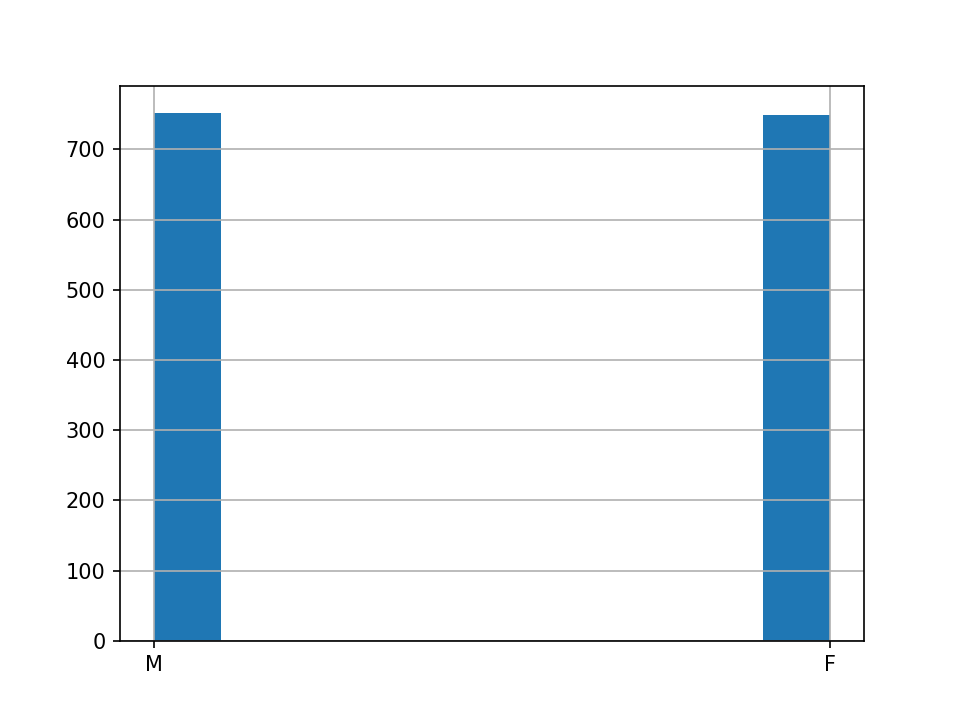

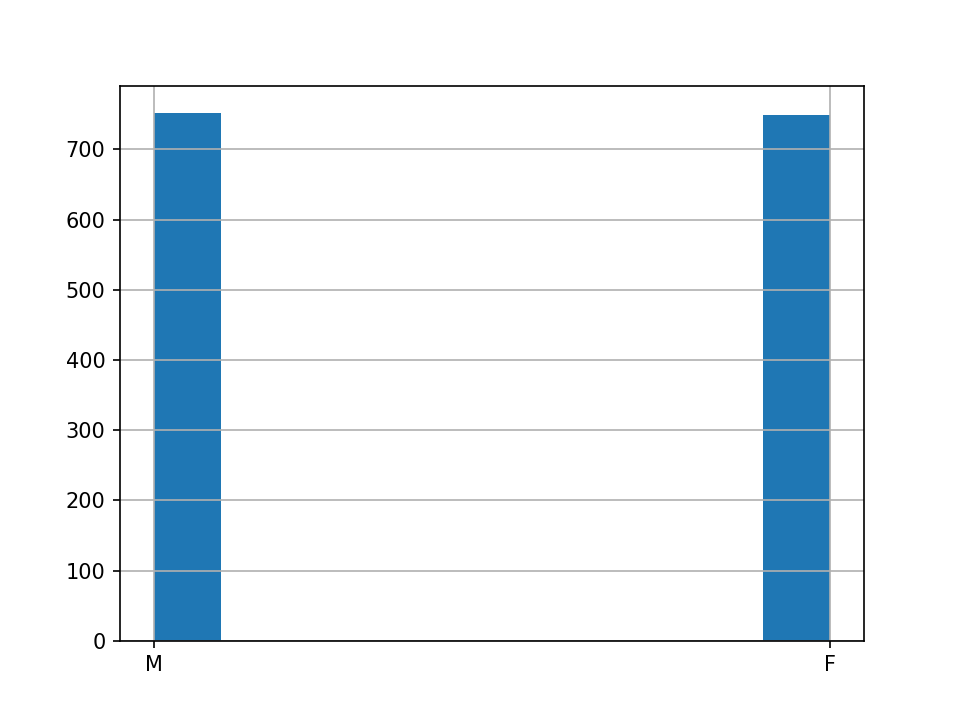

In [8]:
df.BSPT_SEX_CD.hist()
plt.show()

In [9]:
df.filter(like="TRTM")

,TRTM_CASB_STRT_YMD1,TRTM_CASB_CSTR_YMD2_1,TRTM_CASB_STRT_YMD2,TRTM_CASB_CSTR_YMD2_2,TRTM_CASB_STRT_YMD3,TRTM_CASB_CSTR_YMD2_3,TRTM_CASB_STRT_YMD4,TRTM_CASB_CSTR_YMD2_4,TRTM_CASB_STRT_YMD5,TRTM_CASB_CSTR_YMD2_5,TRTM_CASB_STRT_YMD6,TRTM_CASB_CSTR_YMD2_6,TRTM_CASB_STRT_YMD7,TRTM_CASB_CSTR_YMD2_7,TRTM_CASB_STRT_YMD8,TRTM_CASB_CSTR_YMD2_8
0,20080307,20080913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20080217,20080804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,NaN,NaN,NaN
3,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,NaN,NaN,NaN
4,20080910,20090304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,NaN,NaN,NaN
1497,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,NaN,NaN,NaN
1498,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,NaN,NaN,NaN
1499,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,Not Data,NaN,NaN,NaN
